# Описание задания

**Цель лабораторной работы:** изучение линейных моделей, SVM и деревьев решений.



# Задание

1.	Выберите набор данных (датасет) для решения задачи классификации или регресии.
2.	В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3.	С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4.	Обучите 1) одну из линейных моделей, 2) SVM и 3) дерево решений. Оцените качество моделей с помощью трех подходящих для задачи метрик. Сравните качество полученных моделей.
5.	Произведите для каждой модели подбор одного гиперпараметра с использованием GridSearchCV и кросс-валидации.
6.	Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.







# Ход выполнения лабораторной работы

## Выбор датасета

В качестве исходных данных выбираем датасет о террористических атаках. Он содержит около 180 тысячи записей, а также имеет разные столбцы с категориальными данными. Такой датасет может подходить для обучения методом ближайших соседей.

В качестве задачи поставим определение вида атаки по остальным колонкам.

## Проверка и удаление пропусков

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive, files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from google.colab import files
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
os.listdir()
data = pd.read_csv('drive/My Drive/Files/globalterrorismdb_0718dist.csv',
                   sep=",", encoding="iso-8859-1")

Количество пустых колонок огромно, поэтому сначала удалим все столбцы, у которых количество заполненных значений менее 150000 (примерно 5/6 от всего датасета), а затем удалим строки с пустым значением.

In [4]:
# Удаление колонок, содержащих пустые значения
data_temp_1 = data.dropna(axis=1, how='any', thresh=150000)
(data.shape, data_temp_1.shape)

((181691, 135), (181691, 47))

In [5]:
data_new_1 = data_temp_1.dropna(axis=0, how='any')
(data_temp_1.shape, data_new_1.shape)

((181691, 47), (134042, 47))

In [6]:
data_new_1.head()

,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,weapsubtype1_txt,nkill,nwound,property,ishostkid,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY
5,197001010002,1970,1,1,0,217,United States,1,North America,Illinois,...,Unknown Gun Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
6,197001020001,1970,1,2,0,218,Uruguay,3,South America,Montevideo,...,Automatic or Semi-Automatic Rifle,0.0,0.0,0,0.0,PGIS,0,0,0,0
7,197001020002,1970,1,2,0,217,United States,1,North America,California,...,Unknown Explosive Type,0.0,0.0,1,0.0,Hewitt Project,-9,-9,0,-9
8,197001020003,1970,1,2,0,217,United States,1,North America,Wisconsin,...,Molotov Cocktail/Petrol Bomb,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0
9,197001030001,1970,1,3,0,217,United States,1,North America,Wisconsin,...,Gasoline or Alcohol,0.0,0.0,1,0.0,Hewitt Project,0,0,0,0


In [7]:
data2 = data_new_1.drop(["provstate", "eventid",
                 "dbsource", "INT_LOG", "INT_IDEO", "INT_MISC",
                 "INT_ANY", "individual", "weapsubtype1",
                 "weapsubtype1_txt", "property", "vicinity", "crit2",
                 "crit3", "natlty1", "iday", "imonth", "iyear",
                 "extended"], axis=1)
data2.shape

(134042, 28)

## train_test_split



In [0]:
from sklearn.model_selection import train_test_split
attacktype = data2["attacktype1"]
data3 = data2.drop(["attacktype1"], axis=1)
for col in data3.columns:
  dt = str(data[col].dtype)
  if not (dt=='float64' or dt=='int64'):
    data3 = data3.drop([col], axis=1)
data_X_train, data_X_test, data_y_train, data_y_test = train_test_split(
    data3, attacktype, test_size=0.2, random_state=1)

## Обучение 

In [0]:
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import cohen_kappa_score

In [0]:
template = "Значение на тренируемой выборке: {:.2%} \
значение на тестовой выборке: {:.2%}"

In [0]:
class Classifier():
  def __init__(self, method, x_train, y_train, x_test, y_test):
    self._method = method
    self.x_train = x_train
    self.y_train = y_train
    self.x_test = x_test
    self.y_test = y_test
    self.target_1 = []
    self.target_2 = []
   
  def training(self):
    self._method.fit(self.x_train, self.y_train)
    self.target_1 = self._method.predict(self.x_train)
    self.target_2 = self._method.predict(self.x_test)
    
  def result(self, metric):
    print(template.format(metric(self.y_train, self.target_1), 
                      metric(self.y_test, self.target_2)))
    

### Линейные модели

In [13]:
linear = Classifier(SGDClassifier(), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
linear.training()
linear.result(accuracy_score)

Значение на тренируемой выборке: 51.19% значение на тестовой выборке: 51.15%


In [14]:
linear.result(balanced_accuracy_score)

Значение на тренируемой выборке: 19.19% значение на тестовой выборке: 18.80%


In [15]:
linear.result(cohen_kappa_score)

Значение на тренируемой выборке: 22.71% значение на тестовой выборке: 22.90%


### SVM


In [16]:
svm = Classifier(LinearSVC(C=1.0), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
svm.training()
svm.result(accuracy_score)

Значение на тренируемой выборке: 53.30% значение на тестовой выборке: 53.37%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [17]:
svm.result(balanced_accuracy_score)

Значение на тренируемой выборке: 30.71% значение на тестовой выборке: 30.74%


In [18]:
svm.result(cohen_kappa_score)

Значение на тренируемой выборке: 31.82% значение на тестовой выборке: 32.09%


### Дерево решений

In [19]:
tree = Classifier(DecisionTreeClassifier(random_state=1), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
tree.training()
tree.result(accuracy_score)

Значение на тренируемой выборке: 99.00% значение на тестовой выборке: 86.69%


In [20]:
tree.result(balanced_accuracy_score)

Значение на тренируемой выборке: 98.82% значение на тестовой выборке: 59.79%


In [21]:
tree.result(cohen_kappa_score)

Значение на тренируемой выборке: 98.40% значение на тестовой выборке: 78.74%


Видно, что из-за большого числа столбцов лучшим способом становится дерево решений при стандартных гиперпараметрах.


## Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

### Линейные модели

In [22]:
n_range = np.array(range(5,95,10))
n_range = n_range / 100
tuned_parameters = [{'l1_ratio': n_range}]
tuned_parameters

[{'l1_ratio': array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])}]

In [0]:
from sklearn.model_selection import GridSearchCV

cl_lin_gs = GridSearchCV(SGDClassifier(), tuned_parameters, cv=5,
                      scoring='accuracy')
cl_lin_gs.fit(data_X_train, data_y_train)

In [24]:
cl_lin_gs.best_params_

{'l1_ratio': 0.45}

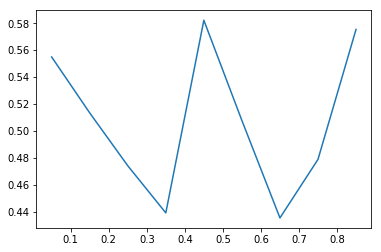

In [25]:
plt.plot(n_range, cl_lin_gs.cv_results_['mean_test_score'])

### SVM

In [31]:
n_range = np.array(range(1,5,1))
tuned_parameters = [{'C': n_range}]
tuned_parameters

[{'C': array([1, 2, 3, 4])}]

In [0]:
cl_svm_gs = GridSearchCV(LinearSVC(), tuned_parameters, cv=3,
                      scoring='accuracy')
cl_svm_gs.fit(data_X_train, data_y_train)

In [33]:
cl_svm_gs.best_params_

{'C': 3}

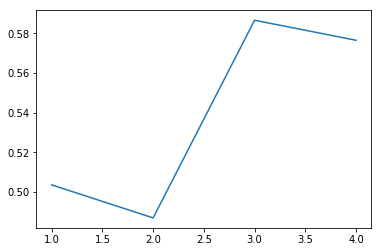

In [34]:
plt.plot(n_range, cl_svm_gs.cv_results_['mean_test_score'])

### Дерево решений

In [35]:
n_range = np.array(range(3,15,1))
tuned_parameters = [{'max_depth': n_range}]
tuned_parameters

[{'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])}]

In [0]:
cl_tree_gs = GridSearchCV(DecisionTreeClassifier(random_state=1), tuned_parameters,
                          cv=5, scoring='accuracy')
cl_tree_gs.fit(data_X_train, data_y_train)

In [37]:
cl_tree_gs.best_params_

{'max_depth': 12}

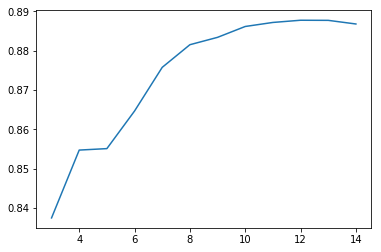

In [38]:
plt.plot(n_range, cl_tree_gs.cv_results_['mean_test_score'])

## Сравнение модели с произвольным и лучшим параметром K

In [39]:
linear2 = Classifier(SGDClassifier(l1_ratio=0.45), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
linear2.training()
linear2.result(accuracy_score)

Значение на тренируемой выборке: 47.70% значение на тестовой выборке: 47.56%


In [40]:
linear.result(accuracy_score)

Значение на тренируемой выборке: 51.19% значение на тестовой выборке: 51.15%


In [41]:
svm2 = Classifier(LinearSVC(C=3.0), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
svm2.training()
svm2.result(accuracy_score)

Значение на тренируемой выборке: 43.80% значение на тестовой выборке: 44.13%


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [42]:
svm.result(accuracy_score)

Значение на тренируемой выборке: 53.30% значение на тестовой выборке: 53.37%


In [43]:
tree2 = Classifier(DecisionTreeClassifier(random_state=1, max_depth=12), data_X_train, 
                    data_y_train, data_X_test, data_y_test)
tree2.training()
tree2.result(accuracy_score)

Значение на тренируемой выборке: 91.15% значение на тестовой выборке: 88.82%


In [44]:
tree.result(accuracy_score)

Значение на тренируемой выборке: 99.00% значение на тестовой выборке: 86.69%


Качество улучшилось только у дерева решений. Это связано с тем, что SGD может попадать в локальные минимумы, из которых не вышло выбраться, а LinearSVC плохо работает на многомерной выборке
